## Correlation of Bstar and mean motion derivative

$n$=mean motion, $a$ = semi-major axis, $\mu$ = gravitational parameter = $G(M+m)$

$n = \sqrt{\frac{\mu}{a^{3}}}$

$$\frac{dn}{dt} = -\frac{3}{2}\mu^{1/2}a^{-5/2}\frac{da}{dt}$$
$$\frac{da}{dt} = \frac{2a^{2}v}{\mu}\dot{\vec{v}}_{D}.\hat{e}_{v}$$
$$\dot{\vec{v}}_{D} = -\frac{1}{2}\frac{C_{D}A}{m}\rho v^{2}\hat{e}_{v}$$

$$\frac{dn}{dt} = 3\mu^{-1/2}a^{-1/2}v^{3}\frac{c_{D}A}{m}\frac{\rho}{2}$$
$$B^{*} = \frac{c_{D}A}{m}\frac{\rho}{2}$$

$$\frac{dn}{dt} = 3\frac{v^{3}}{\sqrt{\mu a}}B^{*}$$

For a satellite at 500 km,

v ~ 7500 m/s, $\mu$ = 3.98e14, $a$ = 6.871e6;
$$\frac{dn}{dt}/B^{*} =  24.1$$

In [1]:
import os
import sys
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import glob

from tletools import TLE
from varname import nameof
from spacepy import pycdf
from numpy import pi
%matplotlib widget

C:\Users\soumy\anaconda3\lib\site-packages\spacepy\time.py:2365: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [30]:
def remove_outliers_zscore(df, column, threshold):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    df_no_outliers = df[z_scores < threshold]
    return df_no_outliers
def remove_outliers(data):
    # Calculate the first and third quartiles (Q1 and Q3)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove values outside the bounds
    cleaned_data=[];
    for i,d in enumerate(data):
        if lower_bound <= d <= upper_bound: 
            cleaned_data.append([i,d])
    cleaned_data= np.array(cleaned_data)        
    return cleaned_data

def running_correlation(df, col1, col2, window_size):
    """
    Calculate the running correlation between two columns of a DataFrame.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        col1 (str): The name of the first column.
        col2 (str): The name of the second column.
        window_size (int): The size of the rolling window.

    Returns:
        pandas.Series: A Series containing the running correlation values.
    """
    if col1 not in df.columns or col2 not in df.columns:
        raise ValueError("Both columns must exist in the DataFrame.")

    # Calculate the running correlation using a rolling window
    rolling_corr = df[col1].rolling(window=window_size).corr(df[col2],method='pearson', min_periods=1)

    return rolling_corr

def tle_ratio(sat_no,start,stop):
    ## sat codes: 0-CHAMP, 1-CNOFS, 2-GOCE, 3-GRACEA, 4-GRACEB, 5-ISS
    ## use start=-1, stop=-1 if using entire satellite lifetime
    satellites = ['CHAMP','CNOFS','GOCE','GRACEA','GRACEB','ISS'] ## add satellites in alphabetical order
    sat_name = satellites[sat_no]
    filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\TLE\\'
    # filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/TLE/'
    os.chdir(filepath)
    filenames = glob.glob('*.txt')
    filename = filenames[sat_no]
    f = open(filename,'r')
    Data = f.readlines()
    f.close()
    epochs=[]; bstar=[]; mean_motion=[]; dn_o2 = []; n =[];
    for i in range(int(len(Data)/2)):
        tle_str = sat_name+'\n' + Data[2*i] + Data[2*i + 1]
        tle_str = tle_str.strip().splitlines()
        tle = TLE.from_lines(*tle_str)
        epochs.append(dt.datetime(tle.epoch_year,1,1,0,0,0) + dt.timedelta(days = tle.epoch_day - 1))
        bstar.append(tle.bstar)
        mean_motion.append(tle.n)
        dn_o2.append(tle.dn_o2)
        n.append(tle.n)
    epochs = pd.DatetimeIndex(epochs)
    
    if start == -1:
        idx0 = np.where(epochs <= dt.datetime(epochs[0].year+1,1,1))[0][-1]
    else:
        idx0 = np.where(epochs <= start)[0][-1]

    if stop == -1:
        idx1 = np.where(epochs >= dt.datetime(epochs[-1].year-1,1,1))[0][0]
    else:
        idx1 = np.where(epochs >= stop)[0][0]

    df = pd.DataFrame({'bstar':bstar,'dn_o2':dn_o2,'n':n},index=pd.DatetimeIndex(epochs))
    df = df.iloc[idx0:idx1,:]
    # df = remove_outliers_zscore(df, 'bstar', threshold=1)
    # df = remove_outliers_zscore(df, 'dn_o2', threshold=1)
    # df = remove_outliers_zscore(df, 'n', threshold=1)
    df['ratio'] = 2*df['dn_o2']/df['bstar']
    # df = remove_outliers_zscore(df, 'ratio', threshold=1)
    return df

def plot_tle(df):
    # df is the dataframe 
    fig,ax = plt.subplots(3,1,figsize=[10,6],gridspec_kw={'height_ratios': [2,1,1]},sharex=True)
    ax[0].plot(df['dn_o2']*2,'-o',ms=2,c='tab:blue',label=r'$\frac{dn}{dt}$')
    ax[0].plot(df['bstar'],'-o',ms=2,c='tab:orange',label=r'$B^{*}$')
    ax[0].legend(loc='upper center',fontsize=13)
    ax2= ax[0].twinx()
    ax2.spines['right'].set_color('r')
    ax2.tick_params(axis='y', colors='r',labelsize=12)     
    ax2.set_ylabel(r'F10.7',color='r',fontsize=13)
    ax2.plot(remove_outliers_zscore(SW_Data_hr, 'F107', threshold=3)['F107'].loc[df.index[0]:df.index[-1]],c='r',alpha=0.6)

    ax[1].plot(running_correlation(df,'dn_o2','bstar',5),'-o',ms=2)
    ax[1].set_ylabel('Pearson r',fontsize=12)

    ax[2].plot(df['ratio'],'-o',ms=2.5)
    # ax[2].set_ylim([-5,15])
    ax[2].set_ylabel(r'$\frac{dn}{dt}/B^{*}$',fontsize=13)
    plt.suptitle(nameof(df)+"_tle")
    filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
    # filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
    os.chdir(filepath);
    filename = nameof(df) + "_tle.jpg";
    plt.savefig(filename,format='jpg',dpi=300)
    
    plt.show()
    
def running_average(input_array, window_size):
    """
    Calculate a running average of a NumPy array.

    Parameters:
        input_array (numpy.ndarray): Input NumPy array.
        window_size (int): Size of the moving window for the running average.

    Returns:
        numpy.ndarray: NumPy array of the same length as the input containing running averages.
    """
    if window_size <= 0 or window_size > len(input_array):
        raise ValueError("Invalid window size")

    cumsum = np.cumsum(input_array)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    
    running_avg = cumsum[window_size - 1:] / window_size
    return np.concatenate((input_array[:window_size-1], running_avg))

def running_correlation(arr1, arr2, window_size):
    """
    Calculate the running correlation between two arrays.

    Parameters:
    - arr1 (array-like): The first array.
    - arr2 (array-like): The second array.
    - window_size (int): The size of the sliding window for calculating correlations.

    Returns:
    - correlations (array): An array of running correlation values.
    """

    # Check if the input arrays have the same length
    if len(arr1) != len(arr2):
        raise ValueError("Input arrays must have the same length.")

    # Initialize an empty array to store correlation values
    correlations = []

    # Iterate through the arrays using a sliding window
    for i in range(len(arr1) - window_size + 1):
        window1 = arr1[i:i + window_size]
        window2 = arr2[i:i + window_size]

        # Calculate the correlation coefficient for the current window
        correlation = np.corrcoef(window1, window2)[0, 1]

        correlations.append(correlation)

    return np.array(correlations)

In [4]:
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/EPB stuff/Data/OMNI Data/'
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\EPB stuff\\Data\\OMNI Data\\'
os.chdir(filepath)
filename = 'omni2_hourly_indices.txt';
SW_Data_hr = pd.DataFrame(np.loadtxt(filename,dtype = float));
time_array = [dt.datetime(int(SW_Data_hr.iloc[i,0]),1,1) + dt.timedelta(days = int(SW_Data_hr.iloc[i,1])-1) + dt.timedelta(hours=SW_Data_hr.iloc[i,2]) for i in range(len(SW_Data_hr))];
SW_Data_hr.index = pd.DatetimeIndex(time_array);
columns = ['Year','DOY','Hour','B0','Bx','By','Bz','Plasma Speed','Flow Pressure','Electric Field','Kp','R','Dst','AP','F107','AE','AL','AU'];
SW_Data_hr.columns = columns;

In [5]:
sat = 'GRACEA'
start = dt.datetime(2005,8,1,0,0,0)
stop = dt.datetime(2005,9,1,0,0,0)
R_e = 6.378 * 10**6
grace1 = tle_ratio(3,-1,-1)
# grace1 = grace1[(grace1.index >= start) & (grace1.index <= stop)]
mu = 3.98e14;

In [6]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\'
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = sat + '_Mehta_' + start.strftime("%Y-%m-%d") +'.csv'
GRACE_Data = pd.read_csv(filename)
GRACE_Data.index = pd.DatetimeIndex(GRACE_Data['Unnamed: 0'])
GRACE_Data = GRACE_Data.drop('Unnamed: 0',axis=1)
df1=GRACE_Data.loc[start:stop]

In [7]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = sat + '_MSIS_jl_' + start.strftime("%Y-%m-%d") + '.csv'
Data_MSIS = pd.read_csv(filename)
Data_MSIS.index = pd.DatetimeIndex(Data_MSIS['Unnamed: 0'])
Data_MSIS = Data_MSIS.loc[start:stop]

In [8]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename='GRACEA_CLL_MSIS_' + start.strftime("%Y-%m-%d")+".csv"
CD_MSIS_CLL = pd.read_csv(filename)
CD_MSIS_CLL.index = pd.DatetimeIndex(Data_MSIS['Unnamed: 0'])


In [9]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = "SGP4_prop_reg_"+sat+'_'+ start.strftime("%Y-%m-%d") + ".csv"
df_in = pd.read_csv(filename)
df_in.index = pd.DatetimeIndex(df_in['Unnamed: 0'])

In [10]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\SPDF\\'
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/SPDF/'
os.chdir(filepath)

filename = 'grace1_20221029054657_14241.cdf';
cdf = pycdf.CDF(filename)
time_array = pd.DatetimeIndex(cdf['Epoch'])
XYZ_TOD = pd.DataFrame(cdf['XYZ_TOD'],columns = ['X','Y','Z'],index = time_array)
RADIUS = pd.DataFrame({'Radius' : list(cdf['RADIUS'])},index = time_array)
RADIUS_int = RADIUS.resample('10S').interpolate(method = 'spline',order = 3)

In [11]:
Z = XYZ_TOD['Z'][(XYZ_TOD.index>=start) & (XYZ_TOD.index<=stop)]
idxz = np.where(np.diff(np.sign(Z)) > 0)[0]
orbit_end = Z.index[idxz] 
time_avg = [orbit_end[i] + (orbit_end[i+1] - orbit_end[i])/2 for i in range(len(orbit_end)-1)]

In [12]:
# # filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
# os.chdir(filepath)
# filename = "SGP4_prop_reg_"+sat + '_'+ start.strftime("%Y-%m-%d") + ".csv"
# df_in = pd.read_csv(filename)
# df_in.index = pd.DatetimeIndex(df_in['Unnamed: 0'])

In [35]:
x1 = (SW_Data_hr.index - SW_Data_hr.index[0])/dt.timedelta(days=1)
x2 = (grace1.index - SW_Data_hr.index[0])/dt.timedelta(days=1)
Y1 = np.interp(x2,x1,SW_Data_hr['F107'])
corr = running_correlation(grace1.bstar,Y1,20)

In [36]:
# plt.figure()
# plt.plot(grace1.index,Y1)
# plt.plot(SW_Data_hr['F107'])

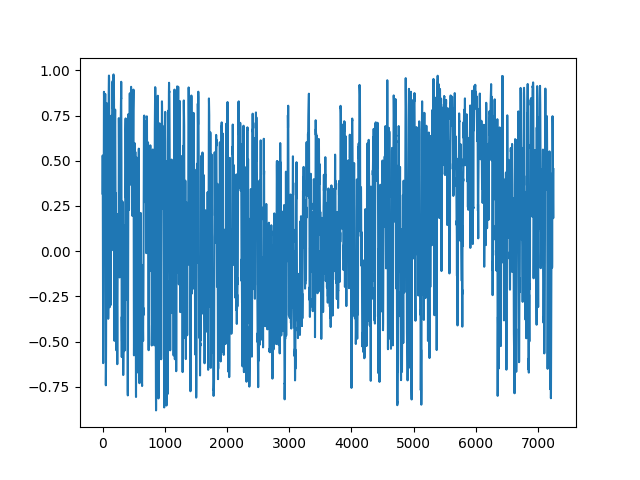

In [37]:
plt.figure()
plt.plot(corr)

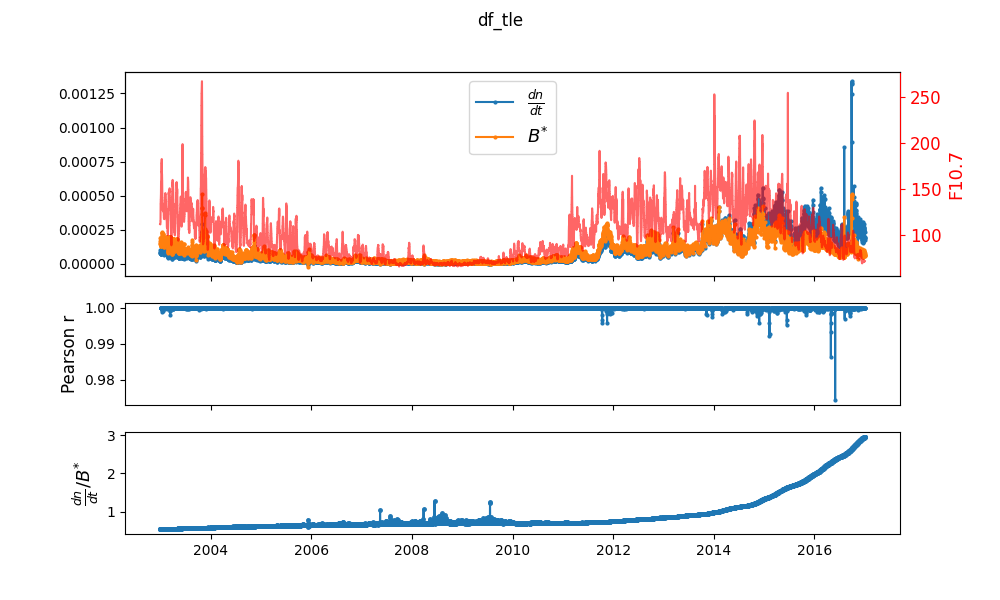

In [15]:
plot_tle(grace1)

## first derivative of mean motion

In [16]:
ratio = 3*(np.sqrt(df_in['Vx']**2 + df_in['Vy']**2 + df_in['Vz']**2)**3)/np.sqrt(mu*df_in['semi_major_axis']*R_e)
ratio_avg = [ratio.loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
ratio_obs = grace1['ratio']*(2*pi/86400)*R_e
X = (grace1.index -start)/dt.timedelta(seconds=1)
# ratio_obs = np.diff(ratio_obs)/np.diff(X)

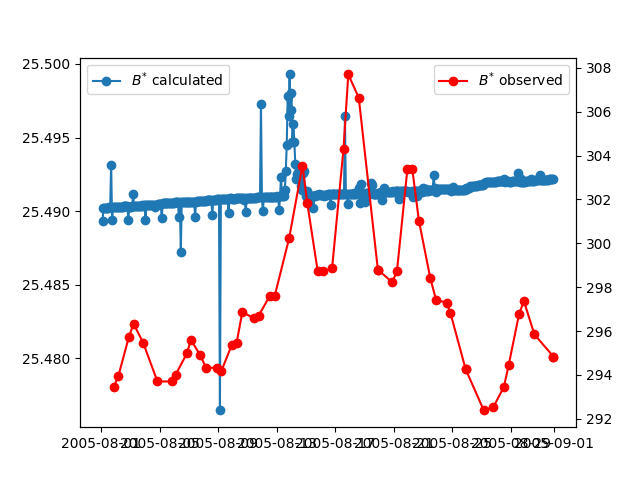

In [24]:
fig,ax = plt.subplots()
ax.plot(time_avg,ratio_avg,'-o',label=r'$B^{*}$ calculated')
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(ratio_obs[(ratio_obs.index>=start)&(ratio_obs.index<=stop)],'-o',c='red',label=r'$B^{*}$ observed')
ax2.legend(loc='upper right')